In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns
from ipywidgets import interact, FloatRangeSlider

# spacy for language processing
import spacy

# sklearn for feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim for topic models
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

# topic model viz
import pyLDAvis
from pyLDAvis.gensim_models import prepare

# evaluate parameter settings
import statsmodels.api as sm

sns.set_style('white')
pyLDAvis.enable_notebook()
stop_words = set(pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', header=None,
                         squeeze=True))

In [2]:
len(stop_words)

319

In [3]:
DATA_DIR = Path('data')

data_path = DATA_DIR / 'earnings_calls'

documents = []
for i, transcript in enumerate(data_path.iterdir()):
    content = pd.read_csv(transcript / 'content.csv')
    documents.extend(content.loc[(content.speaker!='Operator') & (content.content.str.len() > 5), 'content'].tolist())
len(documents)

32047

In [4]:
documents[:1]

["Thank you, James, and welcome, everyone, to Agilent's fourth quarter conference call for fiscal year 2018. With me are Mike McMullen, Agilent's President and CEO; and Bob McMahon Agilent’s Senior Vice President and CFO. Joining in the Q&A after Bob’s comments will be Jacob Thaysen, President of Agilent's Life Science and Applied Markets Group; Sam Raha, President of Agilent's Diagnostics and Genomics Group; and Mark Doak, President of the Agilent CrossLab Group.\nYou can find the press release and information to supplement today's discussion on our website at www.investor.agilent.com. While there, please click on the link for Financial Results under the Financial Information tab. You will find an investor presentation along with revenue breakouts and currency impacts, business segment results and historical financials for Agilent's operations. We will also post a copy of the prepared remarks following this call.\nToday's comments by Mike and Bob will refer to non-GAAP financial measu

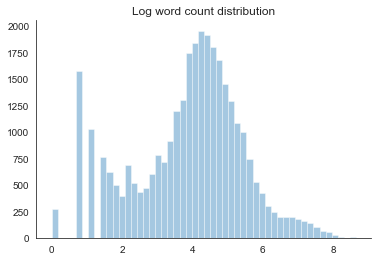

In [5]:
word_count = pd.Series(documents).str.split().str.len()
ax = sns.distplot(np.log(word_count), kde=False)
ax.set_title('Log word count distribution')
sns.despine();

In [6]:
word_count.describe(percentiles=np.arange(.1, 1.0, .1))

count    32047.000000
mean       137.333323
std        283.602026
min          1.000000
10%          4.000000
20%         12.000000
30%         28.000000
40%         45.000000
50%         62.000000
60%         82.000000
70%        111.000000
80%        161.000000
90%        273.000000
max       5718.000000
dtype: float64

In [7]:
token_count = Counter()
for i, doc in enumerate(documents, 1):
    if i % 10000 == 0:
        print(i, end=' ', flush=True)
    token_count.update(doc.split())

10000 20000 30000 

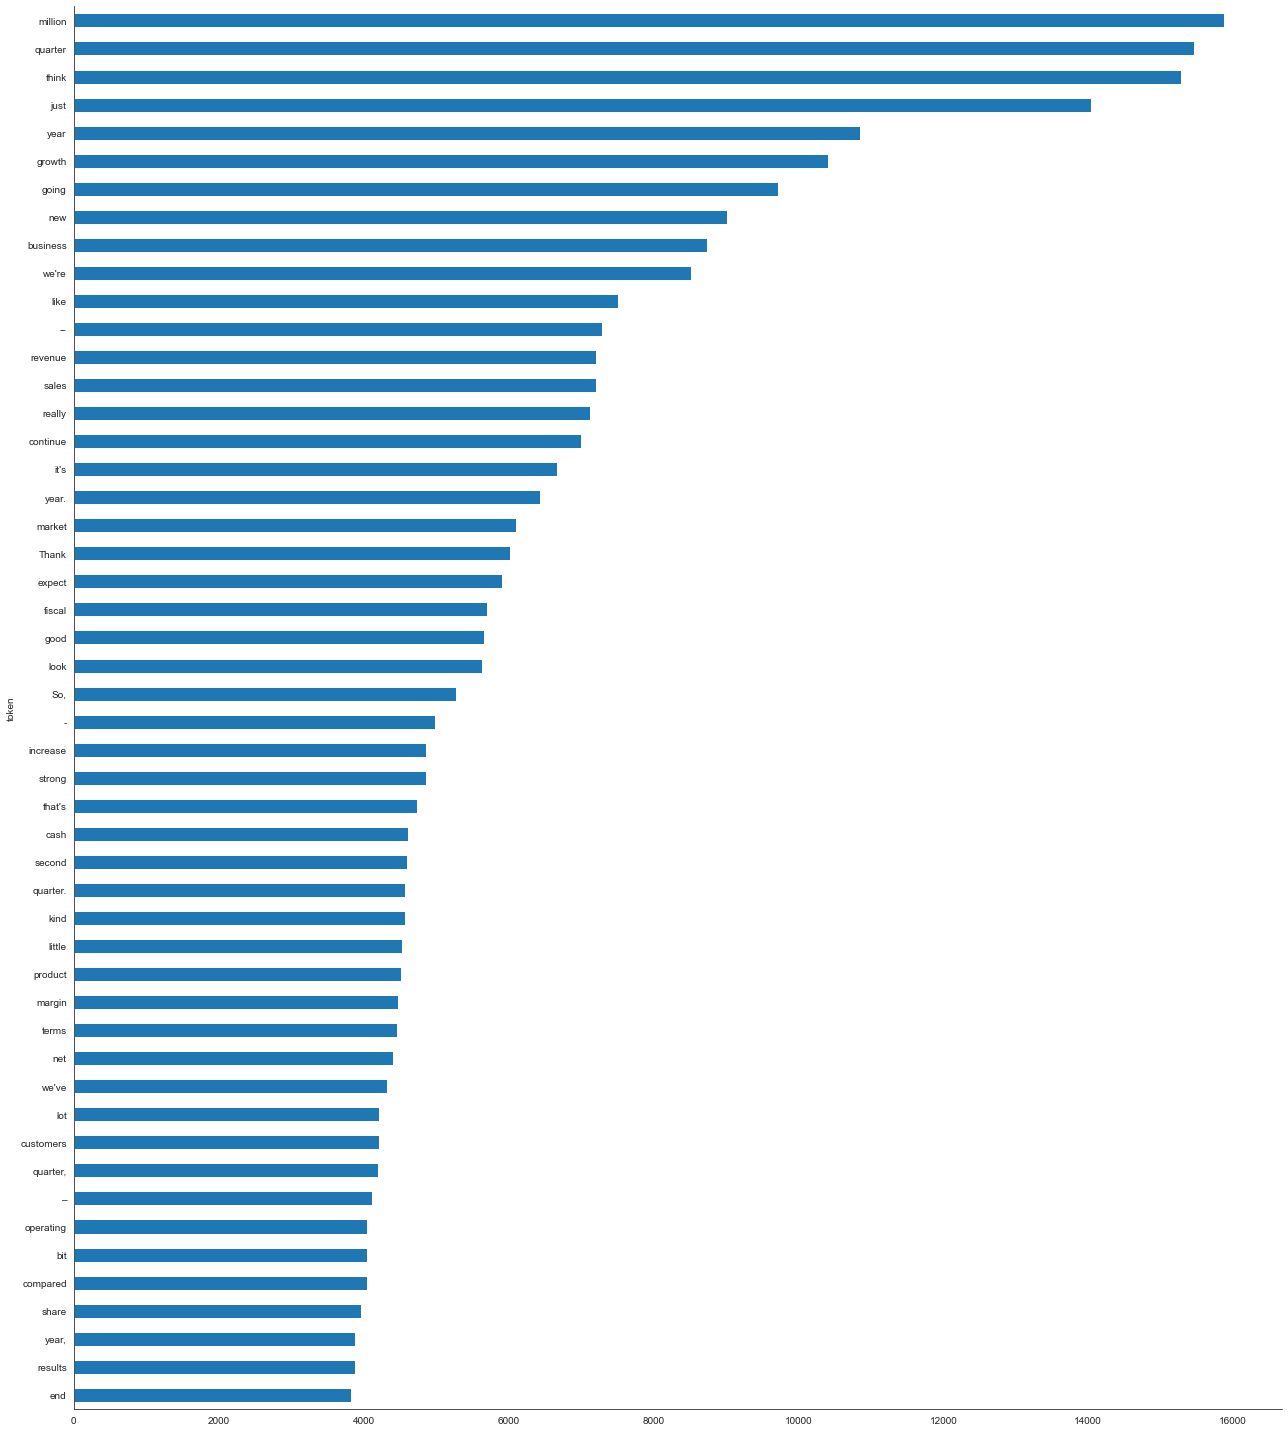

In [8]:
# most frequent token
(pd.DataFrame(token_count.most_common(), columns=['token', 'count'])
 .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)]).set_index('token').squeeze().iloc[:50].sort_values()
 .plot.barh(figsize=(18, 20)))
sns.despine()
plt.tight_layout();

In [10]:
# Preprocess Transcripts
def clean_doc(d):
    doc = []
    for t in d:
        if not any([t.is_stop, t.is_digit, not t.is_alpha, t.is_punct, t.is_space, t.lemma_ == '-PRON-']):
            doc.append(t.lemma_)
    return ' '.join(doc)

nlp = spacy.load('en_core_web_sm')
iter_docs = (doc for doc in documents)

clean_docs = []
for i, document in enumerate(nlp.pipe(iter_docs, batch_size=100, n_process=6), 1):
    if i % 1000 == 0:
        print(f'{i/len(documents):.2%}', end=' ', flush=True)
    clean_docs.append(clean_doc(document))

3.12% 6.24% 9.36% 12.48% 15.60% 18.72% 21.84% 24.96% 28.08% 31.20% 34.32% 37.45% 40.57% 43.69% 46.81% 49.93% 53.05% 56.17% 59.29% 62.41% 65.53% 68.65% 71.77% 74.89% 78.01% 81.13% 84.25% 87.37% 90.49% 93.61% 96.73% 99.85% 

In [11]:
results_path = Path('results', 'earnings_calls')
if not results_path.exists():
    results_path.mkdir()
clean_text = results_path / 'clean_text.txt'
clean_text.write_text('\n'.join(clean_docs))

14083675

In [12]:
clean_text

WindowsPath('results/earnings_calls/clean_text.txt')

In [13]:
# Vectorize data
docs = []
for line in clean_text.read_text().split('\n'):
    line = [t for t in line.split() if t not in stop_words]
    if len(line) > 10:
        docs.append(' '.join(line))

len(docs)

22585

In [15]:
docs[:1]

['thank James welcome Agilent fourth quarter conference fiscal year Mike McMullen Agilent President ceo Bob McMahon Agilent Senior Vice President CFO join Bob comment Jacob Thaysen President Agilent Life Science Applied Markets Group Sam Raha President Agilent Diagnostics Genomics Group Mark Doak President Agilent CrossLab Group press release information supplement today discussion website click link Financial result Financial Information tab investor presentation revenue breakout currency impact business segment result historical financial Agilent operation post copy prepared remark follow today comment Mike Bob refer non gaap financial measure directly comparable GAAP financial metric reconciliation website note reference increase decrease financial metric year year reference revenue growth core basis core revenue growth exclude impact currency acquisition divestiture past month guidance base exchange rate October forward look statement financial performance company statement subject

In [16]:
token_count = Counter()
for i, doc in enumerate(docs, 1):
    if i % 5000 == 0:
        print(i, end=' ', flush=True)
    token_count.update(doc.split())
token_count = pd.DataFrame(token_count.most_common(), columns=['token', 'count'])

5000 10000 15000 20000 

In [21]:
token_count.head(10)

,token,count
0,year,34168
1,quarter,27315
2,million,20580
3,think,17365
4,business,14516
5,growth,12962
6,continue,11796
7,look,11354
8,market,11137
9,increase,10878


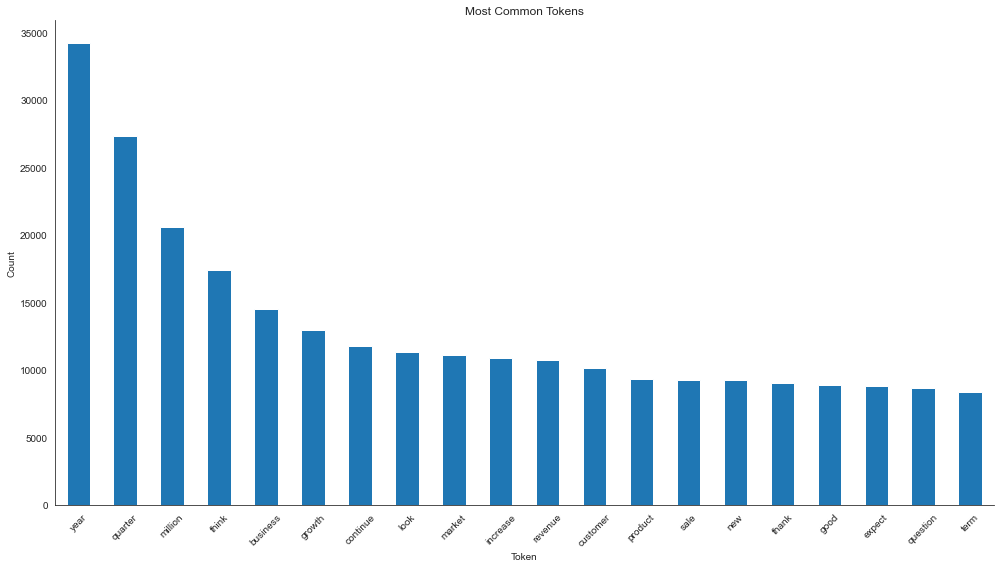

In [22]:
ax = (token_count.set_index('token').squeeze().iloc[:20].sort_values(
    ascending=False).plot.bar(figsize=(14, 8), rot=45, title='Most Common Tokens'))
ax.set_ylabel('Count')
ax.set_xlabel('Token')
sns.despine()
plt.gcf().tight_layout()

In [23]:
frequent_words = token_count.head(50).token.tolist()
binary_vectorizer = CountVectorizer(max_df=1.0, min_df=1, stop_words=frequent_words, max_features=None,
                             binary=True)

binary_dtm = binary_vectorizer.fit_transform(docs)

n_docs, n_tokens = binary_dtm.shape
doc_freq = pd.Series(np.array(binary_dtm.sum(axis=0)).squeeze()).div(binary_dtm.shape[0])
max_unique_tokens = np.array(binary_dtm.sum(axis=1)).squeeze().max()
df_range = FloatRangeSlider(value=[0.0, 1.0], min=0, max=1, step=0.0001, description='Doc. Freq.',
                            disabled=False, continuous_update=True, orientation='horizontal', readout=True,
                            readout_format='.1%', layout={'width': '800px'})

@interact(df_range=df_range)
def document_frequency_simulator(df_range):
    min_df, max_df = df_range
    keep = doc_freq.between(left=min_df, right=max_df)
    left = keep.sum()

    fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
    updated_dtm = binary_dtm.tocsc()[:, np.flatnonzero(keep)]
    unique_tokens_per_doc = np.array(updated_dtm.sum(axis=1)).squeeze()
    sns.distplot(unique_tokens_per_doc, ax=axes[0], kde=False, norm_hist=False)
    axes[0].set_title('Unique Tokens per Doc')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('# Unique Tokens')
    axes[0].set_ylabel('# Documents (log scale)')
    axes[0].set_xlim(0, max_unique_tokens)
    axes[0].yaxis.set_major_formatter(ScalarFormatter())

    term_freq = pd.Series(np.array(updated_dtm.sum(axis=0)).squeeze())
    sns.distplot(term_freq, ax=axes[1], kde=False, norm_hist=False)
    axes[1].set_title('Document Frequency')
    axes[1].set_ylabel('# Tokens')
    axes[1].set_xlabel('# Documents')
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, n_docs)

    title = f'Document/Term Frequency Distribution | # Tokens: {left:,d} ({left/n_tokens:.2%})'
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

D:\99.Dev\Python\pythonProject\lib\site-packages\ipykernel\pylab\backend_inline.py:11: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='Doc. Freq.', layout=Layout(width='800px'…

In [24]:
# Train & Evaluate LDA Model
def show_word_list(model, corpus, top=10, save=False):
    top_topics = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    words, probs = [], []
    for top_topic, _ in top_topics:
        words.append([t[1] for t in top_topic[:top]])
        probs.append([t[0] for t in top_topic[:top]])

    fig, ax = plt.subplots(figsize=(model.num_topics*1.2, 5))
    sns.heatmap(pd.DataFrame(probs).T, annot=pd.DataFrame(words).T, fmt='', ax=ax, cmap='Blues', cbar=False)
    sns.despine()
    fig.tight_layout()
    if save:
        fig.savefig(results_path / 'earnings_call_wordlist', dpi=300)

def show_coherence(model, corpus, tokens, top=10, cutoff=0.01):
    top_topics = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    word_lists = pd.DataFrame(model.get_topics().T, index=tokens)
    order = []
    for w, word_list in word_lists.items():
        target = set(word_list.nlargest(top).index)
        for t, (top_topic, _) in enumerate(top_topics):
            if target == set([t[1] for t in top_topic[:top]]):
                order.append(t)

    fig, axes = plt.subplots(ncols=2, figsize=(15,5))
    title = f'# Words with Probability > {cutoff:.2%}'
    (word_lists.loc[:, order]>cutoff).sum().reset_index(drop=True).plot.bar(title=title, ax=axes[1]);

    umass = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    pd.Series([c[1] for c in umass]).plot.bar(title='Topic Coherence', ax=axes[0])
    sns.despine()
    fig.tight_layout();

def show_top_docs(model, corpus, docs):
    doc_topics = model.get_document_topics(corpus)
    df = pd.concat([pd.DataFrame(doc_topic, columns=['topicid', 'weight']).assign(doc=i)
                    for i, doc_topic in enumerate(doc_topics)])

    for topicid, data in df.groupby('topicid'):
        print(topicid, docs[int(data.sort_values('weight', ascending=False).iloc[0].doc)])
        print(pd.DataFrame(lda.show_topic(topicid=topicid)))

In [26]:
# Vocab Settings
min_df = .005
max_df=.25
ngram_range=(1, 1)
binary = False
vectorizer = CountVectorizer(stop_words=frequent_words, min_df=min_df, max_df=max_df, ngram_range=ngram_range,
                             binary=binary)
dtm = vectorizer.fit_transform(docs)
tokens = vectorizer.get_feature_names()

corpus = Sparse2Corpus(dtm, documents_columns=False)
id2word = pd.Series(tokens).to_dict()
dictionary = Dictionary.from_corpus(corpus, id2word)

In [27]:
dtm.shape

(22585, 1521)

In [28]:
# Model Settings
num_topics=15 # to be extracted latent topics number
chunksize=50000 # number of documents for each training
passes=25 # Number of passes through the corpus during training
update_every=None # 0 for batch, 1 for online iteration
alpha='auto' # controls the prior distribution over topic weights in each document
eta='auto' # the prior distribution over word weights in each topic
decay=0.5 # 50% will be forgotten from the previous lambda
offset=1.0
eval_every=None # Log perplexity is estimated every that many updates
iterations=50
gamma_threshold=0.001
minimum_probability=0.01
minimum_phi_value=0.01
per_word_topics=False

D:\99.Dev\Python\pythonProject\lib\site-packages\seaborn\matrix.py:209: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


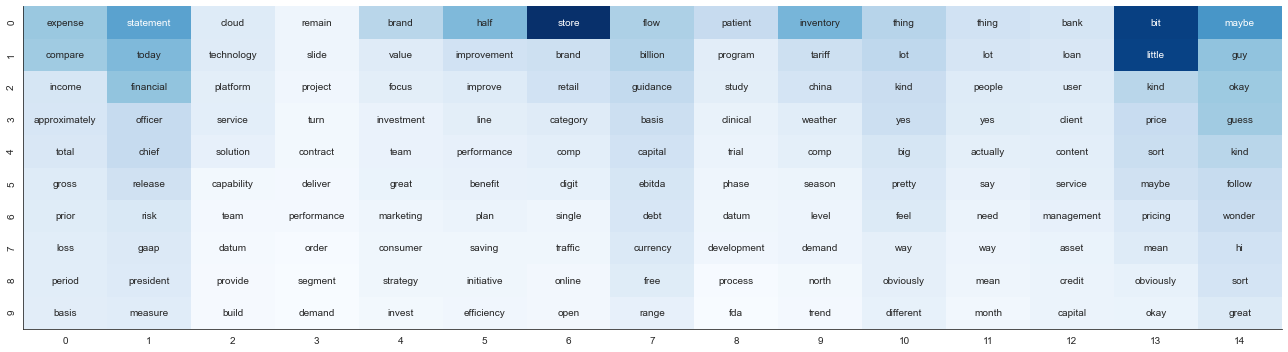

In [33]:
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, chunksize=chunksize,
               update_every=update_every, alpha=alpha, eta=eta, decay=decay, offset=offset,
               eval_every=eval_every, passes=passes, iterations=iterations, gamma_threshold=gamma_threshold,
               minimum_probability=minimum_probability, minimum_phi_value=minimum_phi_value, random_state=42)

show_word_list(model=lda, corpus=corpus, save=True)

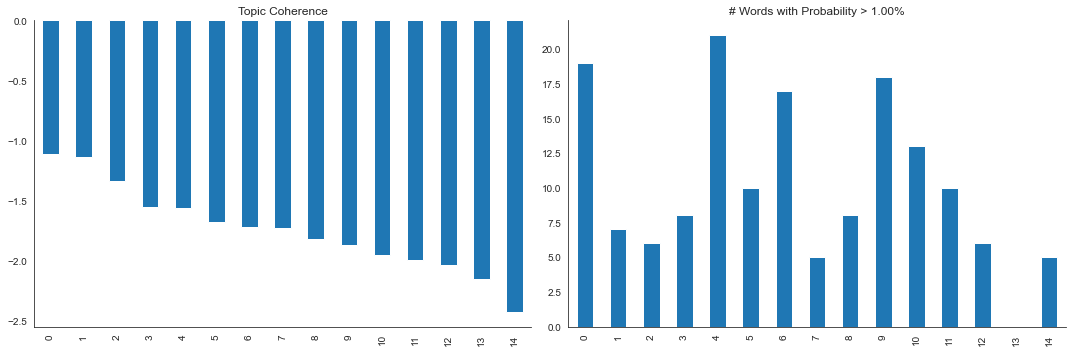

In [30]:
# Topic Coherence: semantic consistency of the topic model results(whether humans would perceive the words and their probabilities associated with topics as meaningful)
show_coherence(model=lda, corpus=corpus, tokens=tokens)

In [32]:
lda.top_topics(corpus=corpus, coherence='u_mass', topn=5)

[([(0.030687464, 'expense'),
   (0.029515961, 'compare'),
   (0.017191088, 'income'),
   (0.01684231, 'approximately'),
   (0.01633209, 'total')],
  -0.8331075771731514),
 ([(0.04095954, 'statement'),
   (0.034612264, 'today'),
   (0.031710986, 'financial'),
   (0.02244023, 'officer'),
   (0.02234988, 'chief')],
  -0.9570753374851664),
 ([(0.024908798, 'brand'),
   (0.014361301, 'value'),
   (0.013221446, 'focus'),
   (0.011044688, 'investment'),
   (0.010939029, 'team')],
  -1.2080048638076288),
 ([(0.034631405, 'half'),
   (0.01875707, 'improvement'),
   (0.014747234, 'improve'),
   (0.013204853, 'line'),
   (0.011938365, 'performance')],
  -1.2164839512298617),
 ([(0.027278932, 'flow'),
   (0.025846368, 'billion'),
   (0.022755621, 'guidance'),
   (0.02049079, 'basis'),
   (0.018706366, 'capital')],
  -1.260710717675354),
 ([(0.014764697, 'cloud'),
   (0.014342582, 'technology'),
   (0.0132494345, 'platform'),
   (0.013028374, 'service'),
   (0.011901653, 'solution')],
  -1.26520506

In [40]:
# pyLDAVis
vis = prepare(lda, corpus, dictionary, mds='tsne')
pyLDAvis.display(vis)

In [41]:
pyLDAvis.save_html(vis, (results_path / f'lda_15.html').as_posix())

In [42]:
# Show documents most represenative of each topic
show_top_docs(model=lda, corpus=corpus, docs=docs)

0 yes think field realize number tool tool qualification space right actually enter term depreciation space upgrade like low productivity tool low price tool perfectly capable production tool stay production different past NXT version basically follow yes upgrade say early upgradability expensive argue economical expect actually limit upgrade possibility tool stay space negotiate customer place factory kind plan develop customer today sure efficient use asset program probably run couple year sure help customer maximum instal base time fully depreciate kind trade upgrade program need work
          0         1
0     thing  0.018864
1       lot  0.017366
2    people  0.014748
3       yes  0.014093
4  actually  0.012748
5       say  0.011448
6      need  0.010600
7       way  0.010141
8      mean  0.009603
9     month  0.008867
1 yeah come leverage slightly quarter say expect come downward net debt level remain fact purchase acquisition new license forward actually think trend line accord